In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error
import requests
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import optuna
import xgboost as xgb
from dateutil.easter import easter
from datetime import timedelta
import plotnine as p9

/Users/alexabraham/anaconda3/envs/forecast_stickers_kaggle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load

In [2]:
sales_daily = (
    pd.read_csv("./data/external/train.csv")
    .assign(

        date = lambda df_: pd.to_datetime(df_['date']),

        country_store = lambda df_: df_['country'].str.cat(df_['store'], sep='|'),
        country_product = lambda df_: df_['country'].str.cat(df_['product'], sep='|'),
        store_product = lambda df_: df_['store'].str.cat(df_['product'], sep='|'),
        country_store_product = lambda df_: df_['country'].str.cat([df_['store'], df_['product']], sep='|')

    )
    .assign(series_id = lambda df_: df_['country_store_product'])
)

In [3]:
sales_daily.head()

,id,date,country,store,product,num_sold,country_store,country_product,store_product,country_store_product,series_id
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,Canada|Discount Stickers,Canada|Holographic Goose,Discount Stickers|Holographic Goose,Canada|Discount Stickers|Holographic Goose,Canada|Discount Stickers|Holographic Goose
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,Canada|Discount Stickers,Canada|Kaggle,Discount Stickers|Kaggle,Canada|Discount Stickers|Kaggle,Canada|Discount Stickers|Kaggle
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,Canada|Discount Stickers,Canada|Kaggle Tiers,Discount Stickers|Kaggle Tiers,Canada|Discount Stickers|Kaggle Tiers,Canada|Discount Stickers|Kaggle Tiers
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,Canada|Discount Stickers,Canada|Kerneler,Discount Stickers|Kerneler,Canada|Discount Stickers|Kerneler,Canada|Discount Stickers|Kerneler
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,Canada|Discount Stickers,Canada|Kerneler Dark Mode,Discount Stickers|Kerneler Dark Mode,Canada|Discount Stickers|Kerneler Dark Mode,Canada|Discount Stickers|Kerneler Dark Mode


In [4]:
def extract_gdp_per_capita(country_code, year):
    """
    Adapted from https://www.kaggle.com/competitions/playground-series-s5e1/discussion/554349.
    """

    url='https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json'
    response = requests.get(url.format(country_code, year)).json()

    return response[1][0]['value']

# per CountryCode-year: request GDP per capita.
# concatenate dataframe of CountryCode | Country | Year | GDP, for integration to Kaggle source

countries_code_map = {
    'Canada': 'CAN', 
    'Finland': 'FIN',
    'Italy': 'ITA',
    'Kenya': 'KEN',
    'Norway': 'NOR',
    'Singapore': 'SGP'
    }

countries_gdp_yearly = []
for country_title, country_code in countries_code_map.items():
    
    values_yearly = [
        {'year': i, 'gdp_per_capita': extract_gdp_per_capita(country_code, i)}
        for i in range(2010, 2019+1)
        ]
    values_yearly = [pd.DataFrame(x, index=[0]) for x in values_yearly]
    values_yearly = pd.concat(values_yearly, axis=0)
    
    values_yearly = values_yearly.assign(
        country = country_title,
        country_code = country_code
        )
    
    countries_gdp_yearly.append(values_yearly)

    print(f"{country_title} ({country_code}) GDP Per Capita extraction complete.")

countries_gdp_yearly = pd.concat(countries_gdp_yearly, axis=0)

countries_gdp_yearly = countries_gdp_yearly.assign(
    gdp_per_capita_log = lambda df_: np.log(df_['gdp_per_capita'])
    )

Canada (CAN) GDP Per Capita extraction complete.
Finland (FIN) GDP Per Capita extraction complete.
Italy (ITA) GDP Per Capita extraction complete.
Kenya (KEN) GDP Per Capita extraction complete.
Norway (NOR) GDP Per Capita extraction complete.
Singapore (SGP) GDP Per Capita extraction complete.


''

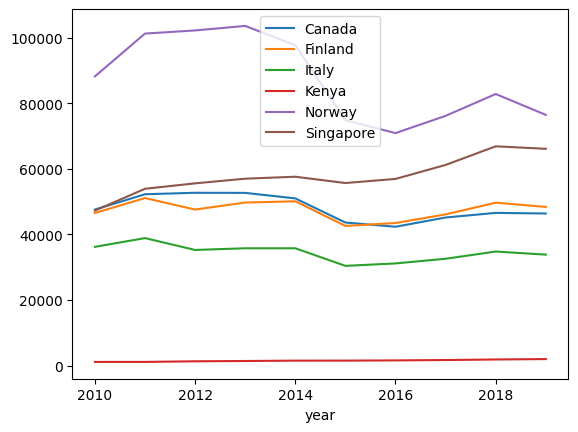

In [5]:
(
    countries_gdp_yearly
    .set_index('year')
    .groupby('country')
    ['gdp_per_capita']
    .plot(legend=True)
)
;

In [6]:
# TODO: is there a better practice for holidays feature representation?
    # in Hyndman's Electricity Load Forecasting Kaggle (https://robjhyndman.com/papers/kaggle-competition.pdf),
    # "holiday effect modelled with a factor variable, taking value zero on a non-work day,
    # some non-zero value day before a non-work day, and a different value the day after a non-work day."
    # meaning -- holiday days pooled, before & after estimated separately?

days_easter0 = [easter(x) for x in range(2010, 2019+1)]
days_easter = pd.DataFrame({'date': days_easter0}).assign(is_easter = 1)

# motivated by exploratory analysis of model errors.
# appears that errors concentrate on days shortly after Easter
dfs_days_special_relative_easter = [days_easter]
for delta_days in [2, 3, 4, 5, 6, 7]:

    df_special = (
        days_easter
        .copy()
        .assign(date = lambda df_: df_['date'] + timedelta(days=delta_days))
        .rename(columns={'is_easter': f'is_easter_plus{delta_days}'})
        )
    dfs_days_special_relative_easter.append(df_special)

days_special_relative_easter = (
    pd.concat(dfs_days_special_relative_easter, axis=0)
    .fillna(0)
    .assign(date = lambda df_: pd.to_datetime(df_['date']))
    )

assert days_special_relative_easter['date'].is_unique

FEATURES_EASTER = [x for x in days_special_relative_easter.columns if 'easter' in x]

In [7]:
def transform_calendar_features(df):

    df = (
        df
        .assign(
            year = lambda df_: df_['date'].dt.year,
            month = lambda df_: df_['date'].dt.month,
            week_of_year = lambda df_: df_['date'].dt.isocalendar().week,
            day_of_week = lambda df_: df_['date'].dt.day_name(),
            # President's Day is the 'third Monday in February'
            day_of_month = lambda df_: df_['date'].dt.day,
            day_of_year = lambda df_: df_['date'].dt.dayofyear,
            # week of month would be ambiguous because, one week may span 2 months,
            days_since_start = lambda df_: (df['date'] - pd.to_datetime("2010-01-01")).dt.days
            )
        .assign(
            # TODO: are periodic feature transforms too rigid?

            # as day_of_year rises, don't expect monotonic relationship with outcome.
            # rather, expect periodic (sinusoidal) relationship.
            # as sin(x) rises, so too does outcome ...
            # ensure one cycle over one year.
            # at baseline, one sinusoidal cycle occurs per 2π
            day_of_year_sin = lambda df_: np.sin(df_['day_of_year'] * 2 * np.pi / 365),
            day_of_year_cos = lambda df_: np.cos(df_['day_of_year'] * 2 * np.pi / 365),

            day_of_month_sin = lambda df_: np.sin(df_['day_of_month'] * 2 * np.pi / 30),
            day_of_month_cos = lambda df_: np.cos(df_['day_of_month'] * 2 * np.pi / 30),

            # exploratory visuals suggest ~2-year cycles
            days_since_start_macro_sin = lambda df_: np.sin(df_['days_since_start'] * 2 * np.pi / 730),
            days_since_start_macro_cos = lambda df_: np.cos(df_['days_since_start'] * 2 * np.pi / 730),
            )
        .assign(
            is_yearend = lambda df_: (
                (df_['month'] == 12) & (df_['day_of_month'].isin([28, 29, 30, 31]))
                ).astype(int)
            )

        )
    
    df = pd.merge(df, days_special_relative_easter, how='left')
    assert df['is_easter'].notnull().any()
    df[FEATURES_EASTER] = df[FEATURES_EASTER].fillna(0)
    
    return df

def integrate_external_features(df):

    df = pd.merge(df, countries_gdp_yearly, how='left')
    assert df['gdp_per_capita'].notnull().all().all()

    return df

def transform_lagged_predictors(df):

    # to ensure proper within-series outcome lags
    # TODO: with lagged features coming into play, how to enforce proper order via indexes?
    df = (
        df
        .sort_values(['series_id', 'date'])
        .assign(
            num_sold_lag1 = lambda df_: df_.groupby('series_id')['num_sold'].shift(1),
            num_sold_lag7 = lambda df_: df_.groupby('series_id')['num_sold'].shift(7)
            )
        )
    
    return df

def transform_logs(df):

    df = (
        df
        .assign(
            num_sold_log = lambda df_: np.log(df_['num_sold']),
            num_sold_lag1_log = lambda df_: np.log(df_['num_sold_lag1']),
        )
    )

    return df

sales_daily = transform_calendar_features(sales_daily)
sales_daily = integrate_external_features(sales_daily)
sales_daily = transform_lagged_predictors(sales_daily)
sales_daily = transform_logs(sales_daily)

# Data Understanding

## Data Description Report: "Surface Properties"

In [8]:
sales_daily['id'].is_unique

True

### Volumetric Analyses

In [9]:
sales_daily.shape

(230130, 39)

In [10]:
sales_daily['series_id'].nunique()

90

In [11]:
sales_daily['date'].nunique()

2557

In [12]:
sales_daily['series_id'].value_counts().value_counts()

count
2557    90
Name: count, dtype: int64

In [13]:
sales_daily['product'].value_counts(dropna=False)

product
Holographic Goose     46026
Kaggle                46026
Kaggle Tiers          46026
Kerneler              46026
Kerneler Dark Mode    46026
Name: count, dtype: int64

In [14]:
sales_daily['country'].value_counts(dropna=False)

country
Canada       38355
Finland      38355
Italy        38355
Kenya        38355
Norway       38355
Singapore    38355
Name: count, dtype: int64

In [15]:
sales_daily['store'].value_counts(dropna=False)

store
Discount Stickers       76710
Premium Sticker Mart    76710
Stickers for Less       76710
Name: count, dtype: int64

### Fields' Types and Values

In [16]:
sales_daily['date'].describe()

count                           230130
mean     2013-07-01 23:59:59.999999744
min                2010-01-01 00:00:00
25%                2011-10-02 00:00:00
50%                2013-07-02 00:00:00
75%                2015-04-02 00:00:00
max                2016-12-31 00:00:00
Name: date, dtype: object

In [17]:
sales_daily['num_sold'].describe()

count    221259.000000
mean        752.527382
std         690.165445
min           5.000000
25%         219.000000
50%         605.000000
75%        1114.000000
max        5939.000000
Name: num_sold, dtype: float64

## Data Quality Report

In [18]:
sales_daily.isnull().mean()

id                            0.000000
date                          0.000000
country                       0.000000
store                         0.000000
product                       0.000000
num_sold                      0.038548
country_store                 0.000000
country_product               0.000000
store_product                 0.000000
country_store_product         0.000000
series_id                     0.000000
year                          0.000000
month                         0.000000
week_of_year                  0.000000
day_of_week                   0.000000
day_of_month                  0.000000
day_of_year                   0.000000
days_since_start              0.000000
day_of_year_sin               0.000000
day_of_year_cos               0.000000
day_of_month_sin              0.000000
day_of_month_cos              0.000000
days_since_start_macro_sin    0.000000
days_since_start_macro_cos    0.000000
is_yearend                    0.000000
is_easter                

In [19]:
# are null sales events concentrated on a particular date?
# doesn't appear so
sales_daily.query("num_sold.isnull()")['date'].value_counts()

date
2010-04-21    7
2010-04-01    7
2010-05-11    7
2010-06-01    7
2010-07-24    6
             ..
2014-03-08    2
2014-03-09    2
2014-03-10    2
2014-03-11    2
2016-12-31    2
Name: count, Length: 2557, dtype: int64

In [20]:
sales_daily.query("num_sold.isnull()")['series_id'].value_counts()

series_id
Canada|Discount Stickers|Holographic Goose       2557
Kenya|Discount Stickers|Holographic Goose        2557
Kenya|Stickers for Less|Holographic Goose        1358
Canada|Stickers for Less|Holographic Goose       1308
Kenya|Premium Sticker Mart|Holographic Goose      646
Canada|Premium Sticker Mart|Holographic Goose     380
Kenya|Discount Stickers|Kerneler                   63
Canada|Discount Stickers|Kerneler                   1
Kenya|Discount Stickers|Kerneler Dark Mode          1
Name: count, dtype: int64

## Data Exploration Report

In [21]:
sales_daily.groupby('series_id')['num_sold'].sum().sort_values(ascending=False)

series_id
Norway|Premium Sticker Mart|Kaggle              8177022.0
Norway|Stickers for Less|Kaggle                 6917719.0
Norway|Premium Sticker Mart|Kaggle Tiers        6757456.0
Norway|Stickers for Less|Kaggle Tiers           5717409.0
Singapore|Premium Sticker Mart|Kaggle           4955153.0
                                                  ...    
Kenya|Discount Stickers|Kerneler                  18902.0
Kenya|Premium Sticker Mart|Holographic Goose      11355.0
Kenya|Stickers for Less|Holographic Goose          6559.0
Canada|Discount Stickers|Holographic Goose            0.0
Kenya|Discount Stickers|Holographic Goose             0.0
Name: num_sold, Length: 90, dtype: float64

In [22]:
# a naive model: series' historical average sales, daily

is_training = (
    (sales_daily['date'] >= pd.to_datetime('2010-01-01'))
    & (sales_daily['date'] < pd.to_datetime("2014-01-01"))
)

is_validation = sales_daily['date'] >= pd.to_datetime("2014-01-01")

# is_training.sum(), is_validation.sum()

# with original train data: using strictly train segment, groupby average
predictions_naive = (
    sales_daily
    .loc[is_training]
    .groupby('series_id')
    [['num_sold']]
    .agg('mean')
    .reset_index(drop=False)
)

predictions_naive_evaluate = pd.merge(
    sales_daily.loc[is_validation],
    predictions_naive.rename(columns={'num_sold': 'yhat'}),
    how='left'
    )

# expect a couple series with all null
predictions_naive.isnull().sum()
# recommended in this discussion: https://www.kaggle.com/competitions/playground-series-s5e1/discussion/554553 
predictions_naive_evaluate = predictions_naive_evaluate.dropna()

mean_absolute_percentage_error(
    predictions_naive_evaluate['num_sold'],
    predictions_naive_evaluate['yhat']
)

0.1789498857721422

In [23]:
predictions_naive_evaluate.shape

(94791, 40)

In [24]:
# a naive model: series' historical average sales, daily

is_training = (
    (sales_daily['date'] >= pd.to_datetime('2013-01-01'))
    & (sales_daily['date'] < pd.to_datetime("2014-01-01"))
)

is_validation = sales_daily['date'] >= pd.to_datetime("2014-01-01")

# is_training.sum(), is_validation.sum()

# with original train data: using strictly train segment, groupby average
predictions_naive = (
    sales_daily
    .loc[is_training]
    .groupby('series_id')
    [['num_sold']]
    .agg('mean')
    .reset_index(drop=False)
)

predictions_naive_evaluate = pd.merge(
    sales_daily.loc[is_validation],
    predictions_naive.rename(columns={'num_sold': 'yhat'}),
    how='left'
    )

# expect a couple series with all null
predictions_naive.isnull().sum()
# recommended in this discussion: https://www.kaggle.com/competitions/playground-series-s5e1/discussion/554553 
predictions_naive_evaluate = predictions_naive_evaluate.dropna()

mean_absolute_percentage_error(
    predictions_naive_evaluate['num_sold'],
    predictions_naive_evaluate['yhat']
)

0.17792885030108446

''

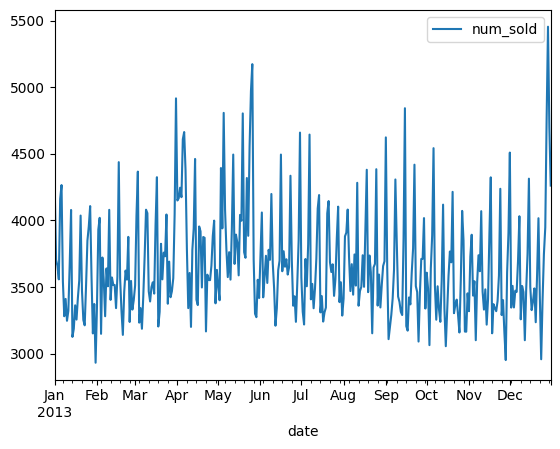

In [25]:
sales_sample_daily = sales_daily.query("series_id == 'Norway|Premium Sticker Mart|Kaggle'")

(
    sales_sample_daily
    .loc[is_training]
    [['date', 'num_sold']]
    .set_index('date')
    .plot
    .line()
)
;

In [26]:
# descend level of abstraction -- 

    # across-year patterns (multi-year business cycles)
    # within-year,
        # month-of-year seasonality
        # week-of-year seasonality
        # day-of-month seasonality
        # day-of-week seasonality

# outcome vs predictors
    # lagged outcome
    # gdp
    # 

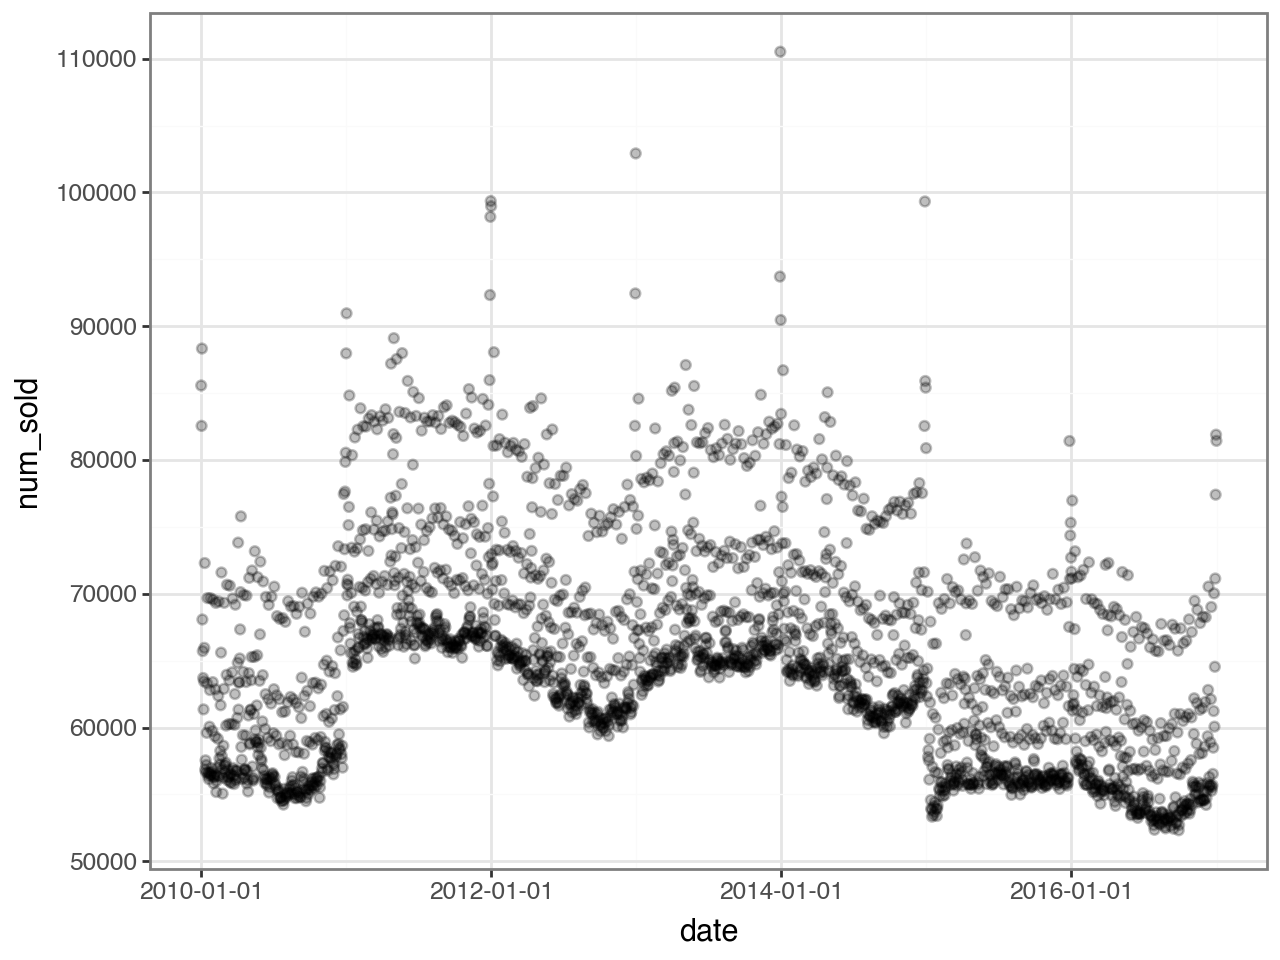

In [27]:
(
    p9.ggplot(sales_daily.groupby(['date'])[['num_sold']].agg('sum').reset_index(drop=False)) + 
    p9.theme_bw() + 
    p9.geom_point(p9.aes('date', 'num_sold'), alpha=0.25)
)

/Users/alexabraham/anaconda3/envs/forecast_stickers_kaggle/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 8871 rows containing non-finite values.


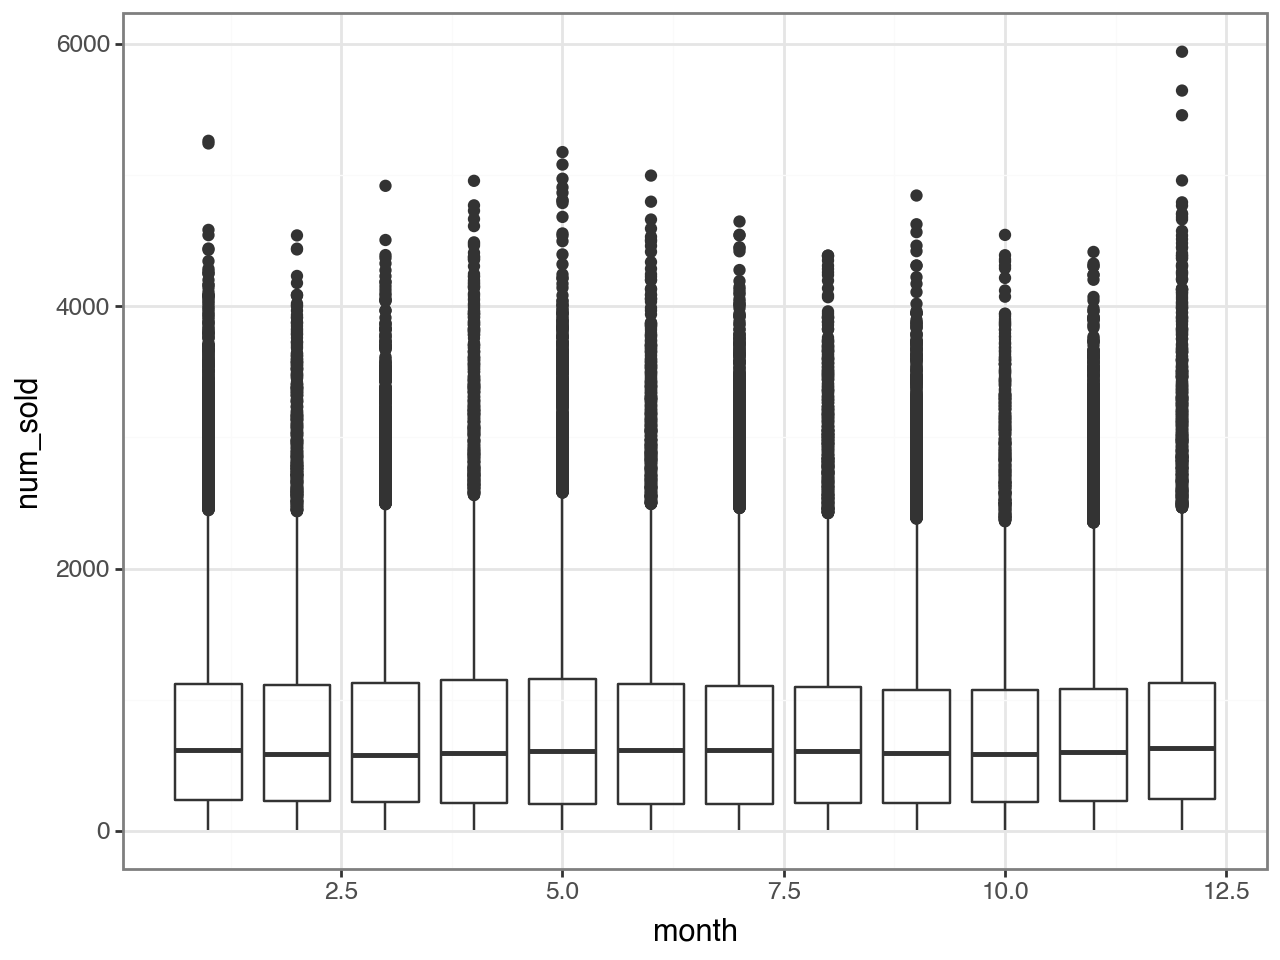

In [28]:
(
    p9.ggplot(sales_daily) + 
    p9.theme_bw() + 
    p9.geom_boxplot(p9.aes('month', 'num_sold', group='month'), alpha=0.1)
)

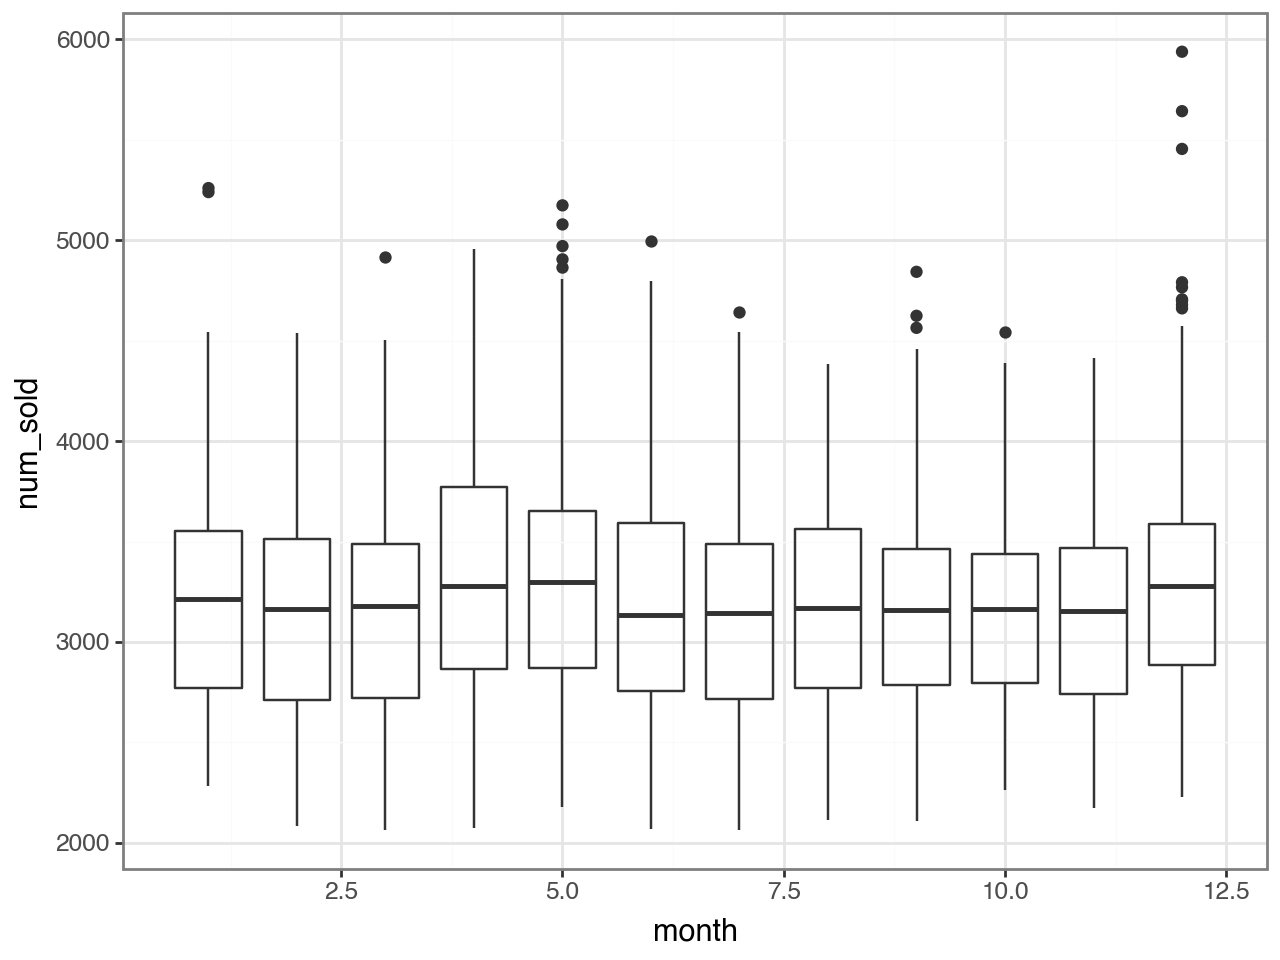

In [29]:
(
    p9.ggplot(sales_daily.query("series_id == 'Norway|Premium Sticker Mart|Kaggle'")) + 
    p9.theme_bw() + 
    p9.geom_boxplot(p9.aes('month', 'num_sold', group='month'), alpha=0.1)
)

/Users/alexabraham/anaconda3/envs/forecast_stickers_kaggle/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 8871 rows containing non-finite values.


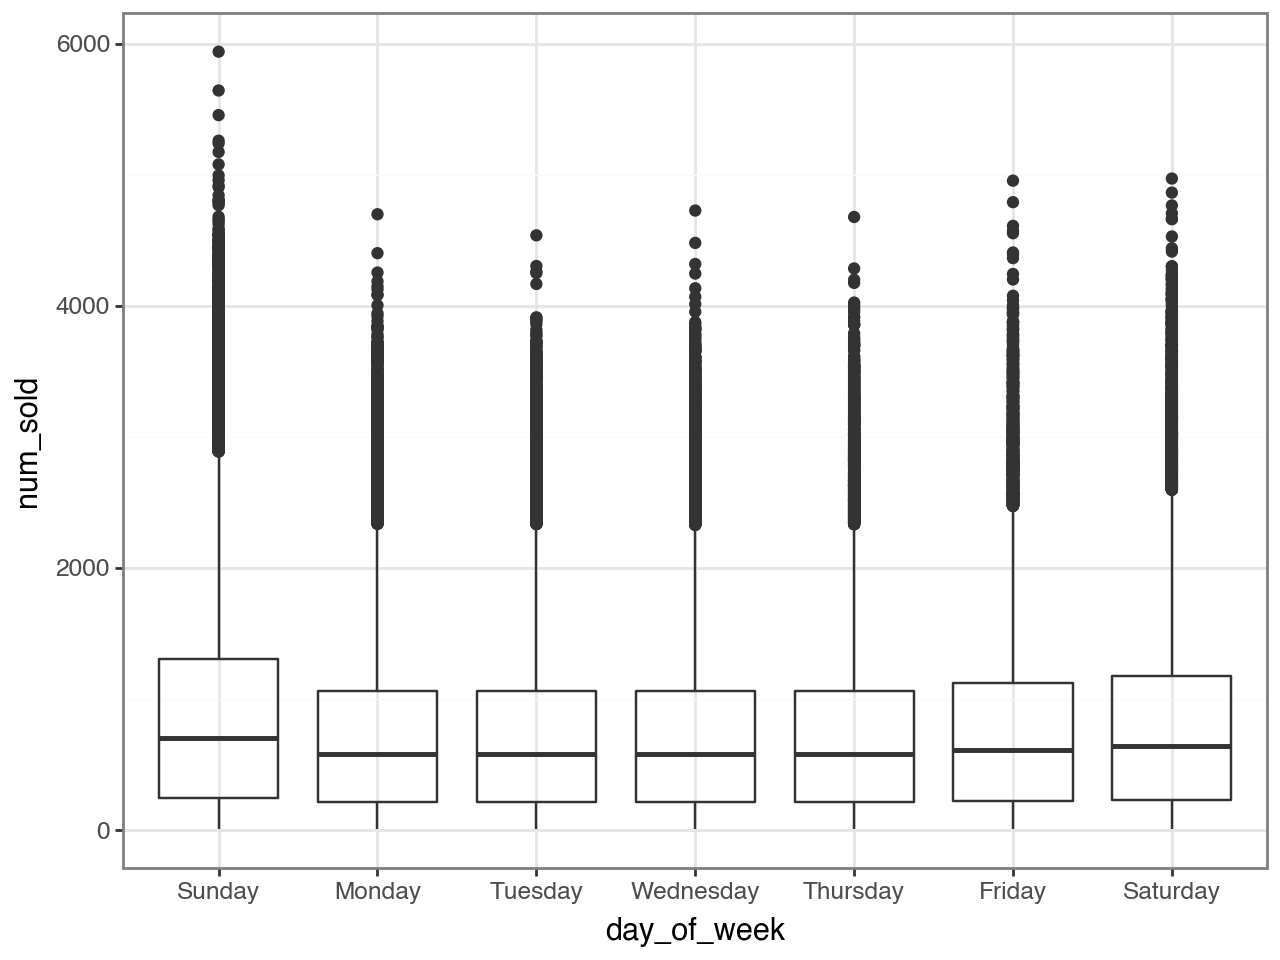

In [30]:
(
    p9.ggplot((
        sales_daily
        .assign(day_of_week = lambda df_: pd.Categorical(
            df_['day_of_week'], 
            ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
            ))
    )) + 
    p9.theme_bw() + 
    p9.geom_boxplot(p9.aes('day_of_week', 'num_sold', group='day_of_week'), alpha=0.1)
)

/Users/alexabraham/anaconda3/envs/forecast_stickers_kaggle/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


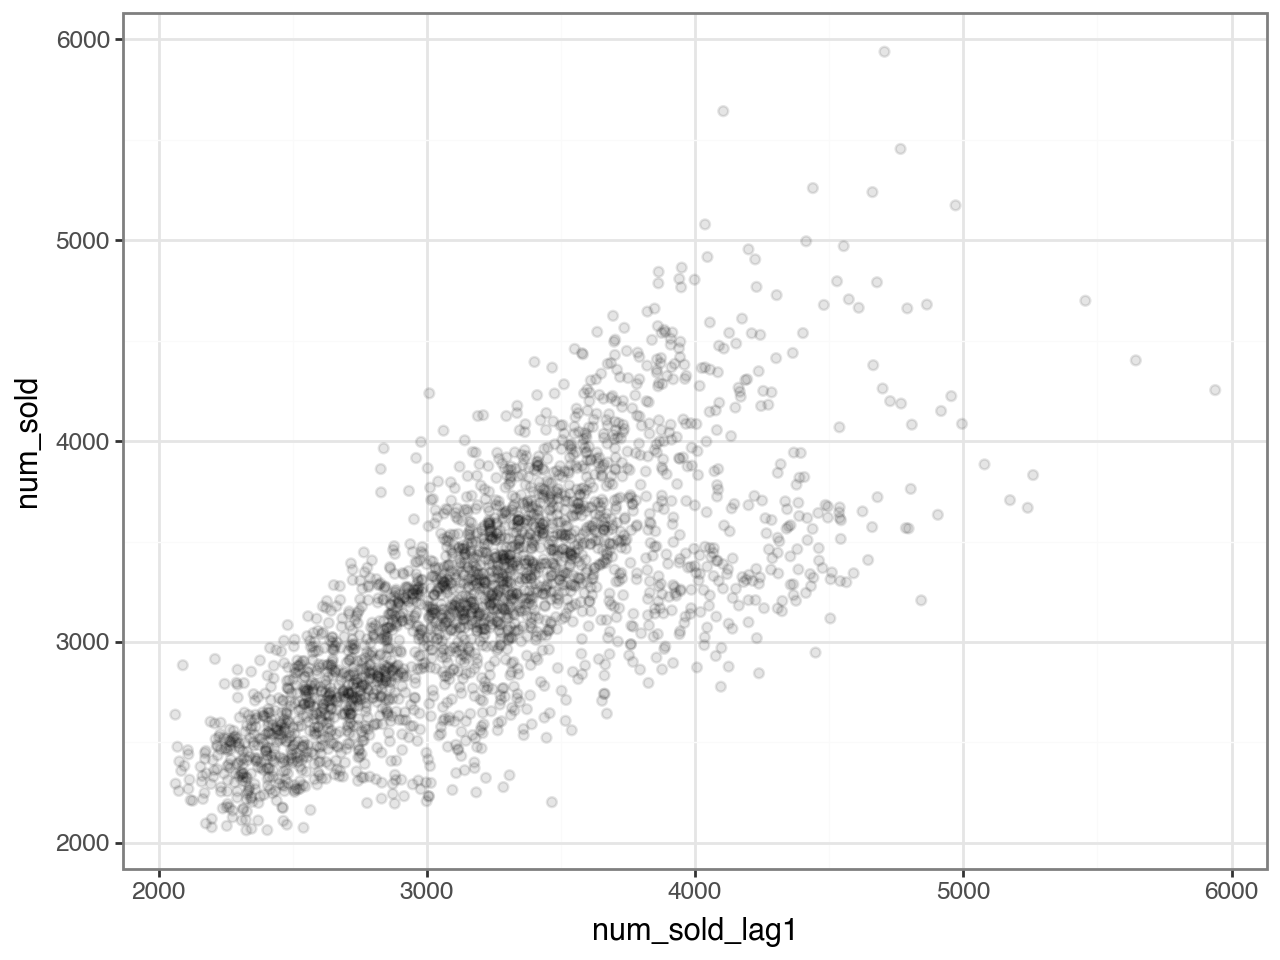

In [31]:
(
    p9.ggplot(sales_daily.query("series_id == 'Norway|Premium Sticker Mart|Kaggle'")) + 
    p9.theme_bw() + 
    p9.geom_point(p9.aes('num_sold_lag1', 'num_sold'), alpha=0.1)
)

/Users/alexabraham/anaconda3/envs/forecast_stickers_kaggle/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 7 rows containing missing values.


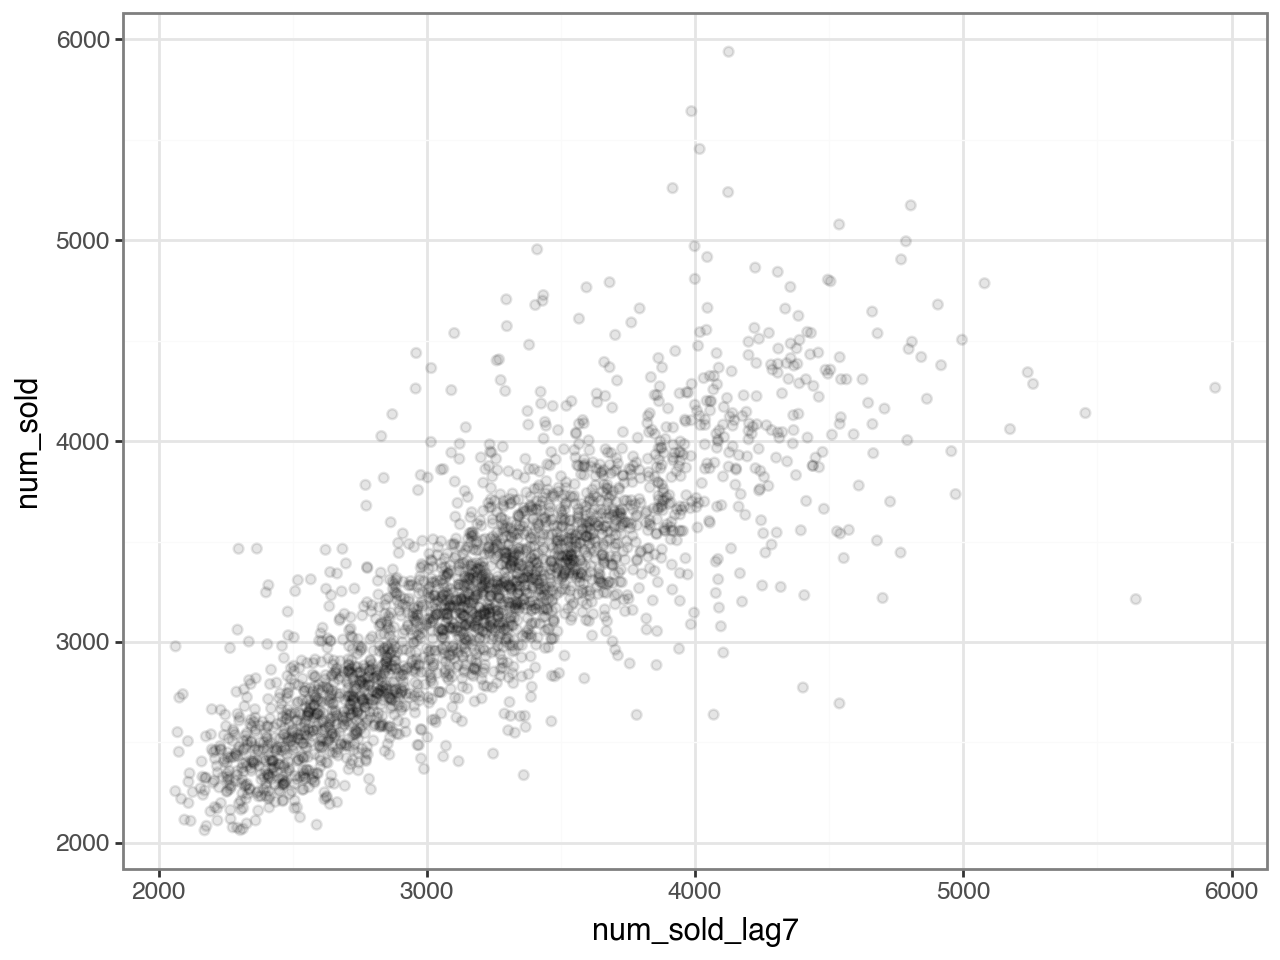

In [32]:
(
    p9.ggplot(sales_daily.query("series_id == 'Norway|Premium Sticker Mart|Kaggle'")) + 
    p9.theme_bw() + 
    p9.geom_point(p9.aes('num_sold_lag7', 'num_sold'), alpha=0.1)
)

# Data Preparation

In [ ]:
FEATURES_TO_ONEHOT = [
    'country', 
    'store',
    'product',
    'country_store',
    'country_product',
    'store_product',
    'country_store_product',
    # year attempted, but then omitted, because year-grained shifts
    # should be explained by exogenous factors, 
    # out-of-sample forecasts that aren't flat
    'month', 
    'week_of_year', 
    'day_of_week'
    ]
FEATURES_NUMERIC_CONTINUOUS = [
    'gdp_per_capita_log',
    'day_of_month', 
    'day_of_month_sin',
    'day_of_month_cos',
    'day_of_year_sin',
    'day_of_year_cos',
    'day_of_year',
    'days_since_start_macro_sin',
    'days_since_start_macro_cos',
    'days_since_start'
    ]
FEATURES_ONEHOT = ['is_yearend'] + FEATURES_EASTER
# TODO: for recursive forecasts, this will need re-standardized each step
FEATURES_AUTOREGRESSIVE = ['num_sold_lag1_log']

FEATURES_SOURCE_FORM = (
    FEATURES_TO_ONEHOT + 
    FEATURES_NUMERIC_CONTINUOUS + 
    FEATURES_ONEHOT
    # FEATURES_AUTOREGRESSIVE
)

ATTRIBUTES = ['series_id', 'date', 'id']

sales_daily_complete = sales_daily.dropna(subset=['num_sold', 'num_sold_lag1_log'])

XY = sales_daily_complete[['num_sold', 'num_sold_log'] + ATTRIBUTES + FEATURES_SOURCE_FORM]

feature_transform_pipeline = ColumnTransformer([
    ('transformer_onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), FEATURES_TO_ONEHOT),
    # TODO: if local model fits by series, might features better standardize by series?
    ('transformer_std', StandardScaler(), FEATURES_NUMERIC_CONTINUOUS)
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
    )
feature_transform_pipeline.set_output(transform='pandas')

# TODO: fix data leakage in preprocessing pipeline!
XY = feature_transform_pipeline.fit_transform(XY)

FEATURES_UNIVERSE = list( set(XY.columns).difference(set(ATTRIBUTES + ['num_sold', 'num_sold_log'])) )

FEATURES_GLOBAL_MODEL = [
    x for x in FEATURES_UNIVERSE
    # experimented with time index (days_since_start) inclusion/exclusion.
    # when included, tree-based method [in isolation] produces flatter, worse forecasts.
        # even when de-trending model precedes that tree-based model, overall performance is worse.
    if not any(stem in x for stem in ['days_since_start', 'num_sold_lag'])
    ]

# TODO: ok if this includes the 3-way interaction?
FEATURES_GLOBAL_TREND_LEVEL_MODEL = [
    x for x in FEATURES_UNIVERSE 
    if any(stem in x for stem in ['country', 'store', 'product', 'gdp', 'num_sold_lag']) # & ('country_store_product' not in x)
    ]

FEATURES_LOCAL_MODEL = [
    x for x in FEATURES_UNIVERSE 
    if not any(stem in x for stem in ['country', 'store', 'product'])
    ]

FEATURES_LOCAL_REMAINDER_MODEL = list( set(FEATURES_LOCAL_MODEL).intersection(set(FEATURES_GLOBAL_MODEL)) )
FEATURES_LOCAL_REMAINDER_MODEL.remove('gdp_per_capita_log')

# Modeling

## Global Model

In [35]:
class TrendRemainderModelPipeline:
    def __init__(
        self, 
        trend_model_features, 
        trend_model_ridge_alpha, 
        remainder_model_features
        ):

        self.trend_model_features = trend_model_features
        self.trend_level_model_ridge_alpha = trend_model_ridge_alpha

        self.remainder_model_features = remainder_model_features

    def fit(self, X, y):

        self.fit_trend_level_model(X, y)
        yhat_trend_level = self.predict_trend_level_model(X)
        y_detrended = y - yhat_trend_level

        self.fit_remainder_model(X, y_detrended)

        return self

    def predict(self, X):

        yhat_trend_level = self.predict_trend_level_model(X)
        yhat_remainder = self.predict_remainder_model(X)

        return yhat_trend_level + yhat_remainder

    def fit_trend_level_model(self, X, y):

        model_trend_level = Ridge(self.trend_level_model_ridge_alpha)
        model_trend_level.fit(X[self.trend_model_features], y)

        self.trend_level_model = model_trend_level

    def fit_remainder_model(self, X, y):

        model_remainder = RandomForestRegressor(n_estimators=100, n_jobs=-1)
        model_remainder.fit(X[self.remainder_model_features], y)

        self.remainder_model = model_remainder

    def predict_trend_level_model(self, X):
        return self.trend_level_model.predict(X[self.trend_model_features])
    
    def predict_remainder_model(self, X):
        return self.remainder_model.predict(X[self.remainder_model_features])

In [36]:
kfolds = [

    # validation set 2014-16 matches ultimate test set's length, 2017-19
    ( 
        ( (XY['date'] >= pd.to_datetime('2010-01-01')) & (XY['date'] < pd.to_datetime("2014-01-01")) ),
        XY['date'] >= pd.to_datetime("2014-01-01")
    ),

    ( 
        ( (XY['date'] >= pd.to_datetime('2010-01-01')) & (XY['date'] < pd.to_datetime("2016-01-01")) ),
        XY['date'] >= pd.to_datetime("2016-01-01")
    )

    ]

kfolds_evaluation = []
for is_training, is_validation in kfolds:

    model_global = RandomForestRegressor(n_estimators=100, n_jobs=-1)
    model_global.fit(
        XY.loc[is_training, FEATURES_GLOBAL_MODEL],
        XY.loc[is_training, 'num_sold_log']
        )
    
    predictions = (
        XY
        .copy()
        .assign(yhat = lambda df_: np.exp(model_global.predict(df_[FEATURES_GLOBAL_MODEL])))
        )
    
    scores = {
        'validation': mean_absolute_percentage_error( 
            predictions.loc[is_validation, 'num_sold'],
            predictions.loc[is_validation, 'yhat']
            ),
        'train': mean_absolute_percentage_error( 
            predictions.loc[is_training, 'num_sold'],
            predictions.loc[is_training, 'yhat']
            )
        }
    
    kfolds_evaluation.append(scores)

kfolds_evaluation

[{'validation': 0.08935703366631097, 'train': 0.018550350844619215},
 {'validation': 0.07147303511365968, 'train': 0.018329829454283988}]

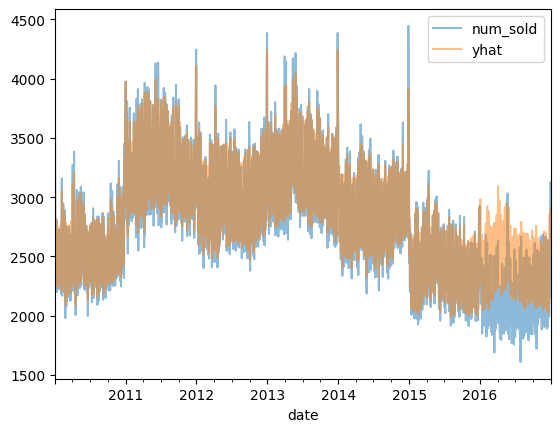

In [37]:
predictions_sample = predictions.query("series_id == 'Norway|Stickers for Less|Kaggle'")

predictions_sample.set_index('date')[['num_sold', 'yhat']].plot.line(alpha=0.5);

In [38]:
# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     model_global, 
#     XY.loc[is_validation, FEATURES_GLOBAL_MODEL],
#     XY.loc[is_validation, 'num_sold_log'], 
#     n_repeats=5, 
#     random_state=777, 
#     n_jobs=-1
# )
# importances = pd.Series(result.importances_mean, index=FEATURES_GLOBAL_MODEL)

# importances = pd.Series(model_global.feature_importances_, index=FEATURES_GLOBAL_MODEL)

In [39]:
kfolds = [

    # validation set 2014-16 matches ultimate test set's length, 2017-19
    ( 
        ( (XY['date'] >= pd.to_datetime('2010-01-01')) & (XY['date'] < pd.to_datetime("2014-01-01")) ),
        XY['date'] >= pd.to_datetime("2014-01-01")
    ),

    ( 
        ( (XY['date'] >= pd.to_datetime('2010-01-01')) & (XY['date'] < pd.to_datetime("2016-01-01")) ),
        XY['date'] >= pd.to_datetime("2016-01-01")
    )

    ]

kfolds_evaluation = []
for is_training, is_validation in kfolds:

    model_global = Ridge(1e-2)
    model_global.fit(
        XY.loc[is_training, FEATURES_GLOBAL_MODEL],
        XY.loc[is_training, 'num_sold_log']
        )
    
    predictions = (
        XY
        .copy()
        .assign(yhat = lambda df_: np.exp(model_global.predict(df_[FEATURES_GLOBAL_MODEL])))
        )
    
    scores = {
        'validation': mean_absolute_percentage_error( 
            predictions.loc[is_validation, 'num_sold'],
            predictions.loc[is_validation, 'yhat']
            ),
        'train': mean_absolute_percentage_error( 
            predictions.loc[is_training, 'num_sold'],
            predictions.loc[is_training, 'yhat']
            )
        }
    
    kfolds_evaluation.append(scores)

kfolds_evaluation

[{'validation': 0.09705147535243419, 'train': 0.09253846516329645},
 {'validation': 0.093198112182682, 'train': 0.09347023605717134}]

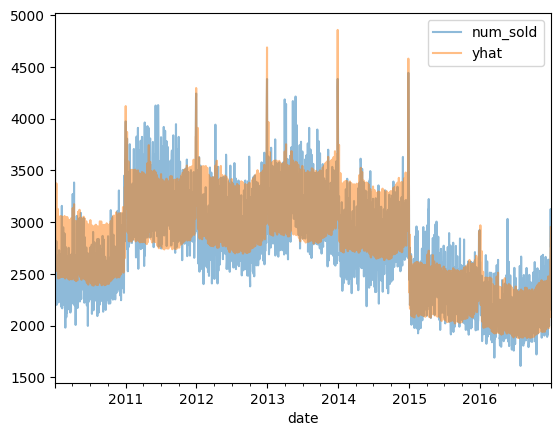

In [40]:
predictions_sample = predictions.query("series_id == 'Norway|Stickers for Less|Kaggle'")
# predictions_sample = predictions.query("series_id == 'Norway|Premium Sticker Mart|Kaggle'")

predictions_sample.set_index('date')[['num_sold', 'yhat']].plot.line(alpha=0.5);

In [41]:
kfolds = [

    # validation set 2014-16 matches ultimate test set's length, 2017-19
    ( 
        ( (XY['date'] >= pd.to_datetime('2010-01-01')) & (XY['date'] < pd.to_datetime("2014-01-01")) ),
        XY['date'] >= pd.to_datetime("2014-01-01")
    ),

    ( 
        ( (XY['date'] >= pd.to_datetime('2010-01-01')) & (XY['date'] < pd.to_datetime("2016-01-01")) ),
        XY['date'] >= pd.to_datetime("2016-01-01")
    )

    ]

kfolds_evaluation = []
for is_training, is_validation in kfolds:

    model_global_pipeline = TrendRemainderModelPipeline(
        trend_model_features=FEATURES_GLOBAL_TREND_LEVEL_MODEL,
        trend_model_ridge_alpha=1e-2,
        remainder_model_features=FEATURES_GLOBAL_MODEL
        )
    model_global_pipeline.fit(
        XY.loc[is_training].drop(columns='num_sold_log'),
        XY.loc[is_training, 'num_sold_log']
        )
    
    predictions = XY.copy()
    predictions = (
        predictions
        .assign(yhat_log = lambda df_: model_global_pipeline.predict(df_))
        .assign(yhat = lambda df_: np.exp(df_['yhat_log']) )
        )
    
    scores = {
        'validation': mean_absolute_percentage_error( 
            predictions.loc[is_validation, 'num_sold'],
            predictions.loc[is_validation, 'yhat']
            ),
        'train': mean_absolute_percentage_error( 
            predictions.loc[is_training, 'num_sold'],
            predictions.loc[is_training, 'yhat']
            )
        }
    
    kfolds_evaluation.append(scores)

kfolds_evaluation

[{'validation': 0.06809932488562725, 'train': 0.017021068988059725},
 {'validation': 0.06286565252351593, 'train': 0.017021792979670176}]

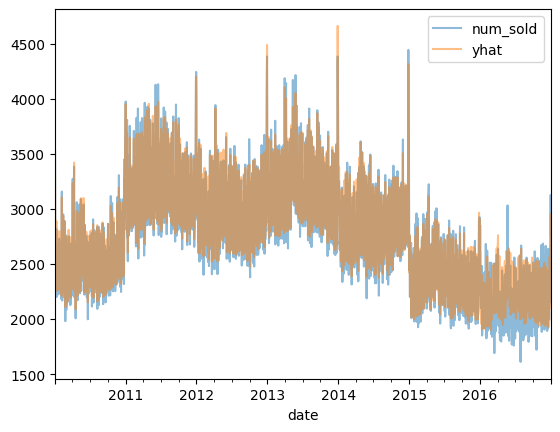

In [42]:
predictions_sample = predictions.query("series_id == 'Norway|Stickers for Less|Kaggle'")
# predictions_sample = predictions.query("series_id == 'Norway|Premium Sticker Mart|Kaggle'")

predictions_sample.set_index('date')[['num_sold', 'yhat']].plot.line(alpha=0.5);

In [43]:
# def objective(trial):

#     ROUNDS_COUNT = 500

#     param = {
#         "objective": "reg:squarederror",
#         "booster": trial.suggest_categorical(
#             "booster", ["gbtree", "gblinear", "dart"]
#         ),
#         "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
#         "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
#         "subsample": trial.suggest_float("subsample", 0.4, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
#         'device': 'cuda',
#         'tree_method': 'hist'
#     }

#     if param["booster"] in ["gbtree", "dart"]:
#         param["max_depth"] = trial.suggest_int("max_depth", 1, 9, step=2)

#         param["min_child_weight"] = trial.suggest_int("min_child_weight", 1, 10)
#         param["eta"] = trial.suggest_float("eta", 1e-5, 0.01, log=True)

#         param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
#         param["grow_policy"] = trial.suggest_categorical(
#             "grow_policy", ["depthwise", "lossguide"]
#         )

#     if param["booster"] == "dart":
#         param["sample_type"] = trial.suggest_categorical(
#             "sample_type", ["uniform", "weighted"]
#         )
#         param["normalize_type"] = trial.suggest_categorical(
#             "normalize_type", ["tree", "forest"]
#         )
#         param["rate_drop"] = trial.suggest_float(
#             "rate_drop", 1e-8, 1.0, log=True
#         )
#         param["skip_drop"] = trial.suggest_float(
#             "skip_drop", 1e-8, 1.0, log=True
#         )


#     kfolds_evaluation = []
#     for is_training, is_validation in kfolds:

#         model_global = Ridge(1e-2)
#         model_global.fit(
#             XY.loc[is_training, FEATURES_GLOBAL_TREND_LEVEL_MODEL],
#             XY.loc[is_training, 'num_sold_log']
#             )
        
#         predictions = (
#             XY
#             .copy()
#             .assign(yhat_trend_log = lambda df_: model_global.predict(df_[FEATURES_GLOBAL_TREND_LEVEL_MODEL]))
#             .assign(num_sold_log_detrend = lambda df_: df_['num_sold_log'] - df_['yhat_trend_log'])
#             )

#         dtrain = xgb.DMatrix(
#             predictions.loc[is_training, FEATURES_GLOBAL_MODEL], 
#             label=predictions.loc[is_training, 'num_sold_log_detrend']
#             )
#         dtest = xgb.DMatrix(predictions[FEATURES_GLOBAL_MODEL])

#         model_global = xgb.train(param, dtrain, ROUNDS_COUNT)
        
#         yhat_remainder = model_global.predict(dtest)
#         predictions = (
#             predictions
#             .assign(yhat_remainder = yhat_remainder)
#             .assign(yhat = lambda df_: np.exp(df_['yhat_trend_log'] + df_['yhat_remainder']))
#             )

#         scores = {
#             'validation': mean_absolute_percentage_error( 
#                 predictions.loc[is_validation, 'num_sold'],
#                 predictions.loc[is_validation, 'yhat']
#                 ),
#             'train': mean_absolute_percentage_error( 
#                 predictions.loc[is_training, 'num_sold'],
#                 predictions.loc[is_training, 'yhat']
#                 )
#             }
        
#         kfolds_evaluation.append(scores)

#     score_overall = np.mean([ 
#         kfolds_evaluation[0]['validation'], 
#         kfolds_evaluation[1]['validation'] 
#         ])
    
#     return score_overall

# study = optuna.create_study()

# study.optimize(
#     objective,
#     n_trials=50,
#     catch=(ValueError,),
#     n_jobs=-1,
#     timeout=12 * 60 * 60,
# )

In [44]:
model_global = TrendRemainderModelPipeline(
        trend_model_features=FEATURES_GLOBAL_TREND_LEVEL_MODEL,
        trend_model_ridge_alpha=1e-2,
        remainder_model_features=FEATURES_GLOBAL_MODEL
        )
model_global.fit(XY.drop(columns='num_sold_log'), XY['num_sold_log'])

## Local Models

In [45]:
# from previous retail forecasting competitions' leaders,
# plus theoretically expected heterogeneity between series: 
# one model per segment

segments_XY = {grp: df for grp, df in XY.groupby('series_id')}

# even when split into many dataframes, *index-based* subsets.
# indexes maintained when dataframe splits.
kfolds = [

    # validation set 2014-16 matches ultimate test set's length, 2017-19
    ( 
        ( (XY['date'] >= pd.to_datetime('2010-01-01')) & (XY['date'] < pd.to_datetime("2014-01-01")) ),
        XY['date'] >= pd.to_datetime("2014-01-01")
    ),

    ( 
        ( (XY['date'] >= pd.to_datetime('2010-01-01')) & (XY['date'] < pd.to_datetime("2016-01-01")) ),
        XY['date'] >= pd.to_datetime("2016-01-01")
    )

    ]

kfolds_evaluation = []
for is_training, is_validation in kfolds:

    # per group: fit model on train, predict on validation
    # WARNING: one model instance, then fitting it on each segment,
    # does not imply separate model objects. they're all tied together.
        # model = LinearRegression()
    segments_models = {
        grp: Ridge(1e-1).fit(
            XY.loc[is_training, FEATURES_LOCAL_MODEL], 
            XY.loc[is_training, 'num_sold_log']
            )
        for grp, XY in segments_XY.items()
        }
    
    # segments_predictions = []
    # for grp, df in segments_XY.items():

    #     predictions_grp = (
    #         df
    #         .copy()
    #         .assign(num_sold_log_lag1_actual = lambda df_: df_['num_sold_lag1_log'])
    #         )

    #     # predict training observations - lagged outcome already known
    #     predictions_grp = (
    #         predictions_grp
    #         .assign(
    #             yhat = lambda df_: np.exp(segments_models[grp].predict(df_[FEATURES_LOCAL_MODEL])) 
    #         )
    #     )

    #     # per validation set obs --
    #         # predict step
    #         # lag to next
    #         # predict next step
    #     # is_validation indexes taken from entire subjects dataframe
    #     predictions_grp.loc[is_validation, 'yhat'] = None
    #     predictions_validate_grp = predictions_grp.loc[is_validation]
    #     for i in range(predictions_validate_grp.shape[0]):
            
    #         index_current = predictions_validate_grp.index[i]
    #         Xt = predictions_validate_grp.iloc[[i]][FEATURES_LOCAL_MODEL]
    #         yhat_log = segments_models[grp].predict(Xt)[0]
    #         predictions_validate_grp.loc[index_current, 'yhat'] = np.exp(yhat_log)

    #         if i+1 < predictions_validate_grp.shape[0]:
    #             index_next = predictions_validate_grp.index[i+1]
    #             predictions_validate_grp.loc[index_next, 'num_sold_lag1_log'] = yhat_log

    #     predictions_grp.loc[is_validation, ['yhat', 'num_sold_lag1_log']] = (
    #         predictions_validate_grp.loc[is_validation, ['yhat', 'num_sold_lag1_log']]
    #         )

    #     segments_predictions.append(predictions_grp)

    segments_predictions = [
        df.assign(
            yhat = lambda df_: np.exp(segments_models[grp].predict(df_[FEATURES_LOCAL_MODEL])) 
            )
        for grp, df in segments_XY.items()
        ]

    predictions = pd.concat(segments_predictions, axis=0)

    scores = {
        'validation': mean_absolute_percentage_error( 
            predictions.loc[is_validation, 'num_sold'],
            predictions.loc[is_validation, 'yhat']
            ),
        'train': mean_absolute_percentage_error( 
            predictions.loc[is_training, 'num_sold'],
            predictions.loc[is_training, 'yhat']
            )
        }
    
    kfolds_evaluation.append(scores)

In [46]:
kfolds_evaluation

[{'validation': 0.07281167695235126, 'train': 0.04360596520670961},
 {'validation': 0.049363513387974386, 'train': 0.04426349660468777}]

<Axes: xlabel='date'>

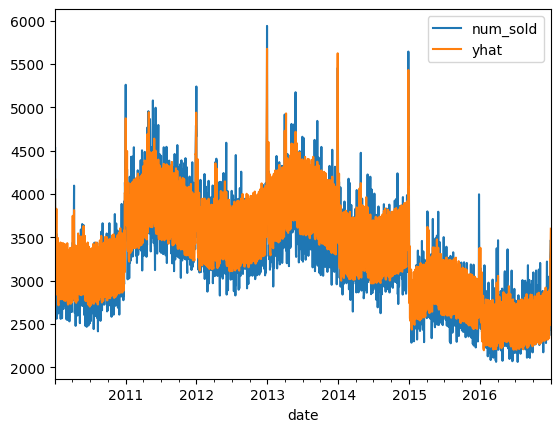

In [47]:
predictions_sample = predictions.query("series_id == 'Norway|Premium Sticker Mart|Kaggle'")

predictions_sample.set_index('date')[['num_sold', 'yhat']].plot.line()

In [48]:
def objective(trial):

    parameters = {'alpha': trial.suggest_float("alpha", 1e-4, 1, log=True)}

    kfolds_evaluation = []
    for is_training, is_validation in kfolds:

        # per group: fit model on train, predict on validation
        segments_models = {
            grp: Ridge(**parameters).fit(
                XY.loc[is_training, FEATURES_LOCAL_MODEL], 
                XY.loc[is_training, 'num_sold_log']
                )
            for grp, XY in segments_XY.items()
            }
        
        # segments_predictions = []
        # for grp, df in segments_XY.items():

        #     predictions_grp = (
        #         df
        #         .copy()
        #         .assign(num_sold_log_lag1_actual = lambda df_: df_['num_sold_lag1_log'])
        #         )

        #     # predict training observations - lagged outcome already known
        #     predictions_grp = (
        #         predictions_grp
        #         .assign(
        #             yhat = lambda df_: np.exp(segments_models[grp].predict(df_[FEATURES_LOCAL_MODEL])) 
        #         )
        #     )

        #     # per validation set obs --
        #         # predict step
        #         # lag to next
        #         # predict next step
        #     # is_validation indexes taken from entire subjects dataframe
        #     predictions_grp.loc[is_validation, 'yhat'] = None
        #     predictions_validate_grp = predictions_grp.loc[is_validation]
        #     for i in range(predictions_validate_grp.shape[0]):
                
        #         index_current = predictions_validate_grp.index[i]
        #         Xt = predictions_validate_grp.iloc[[i]][FEATURES_LOCAL_MODEL]
        #         yhat_log = segments_models[grp].predict(Xt)[0]
        #         predictions_validate_grp.loc[index_current, 'yhat'] = np.exp(yhat_log)

        #         if i+1 < predictions_validate_grp.shape[0]:
        #             index_next = predictions_validate_grp.index[i+1]
        #             predictions_validate_grp.loc[index_next, 'num_sold_lag1_log'] = yhat_log

        #     predictions_grp.loc[is_validation, ['yhat', 'num_sold_lag1_log']] = (
        #         predictions_validate_grp.loc[is_validation, ['yhat', 'num_sold_lag1_log']]
        #         )

        #     segments_predictions.append(predictions_grp)

        segments_predictions = [
            df.assign(
                yhat = lambda df_: np.exp(segments_models[grp].predict(df_[FEATURES_LOCAL_MODEL])) 
                )
            for grp, df in segments_XY.items()
            ]

        predictions = pd.concat(segments_predictions, axis=0)

        scores = {
            'validation': mean_absolute_percentage_error( 
                predictions.loc[is_validation, 'num_sold'],
                predictions.loc[is_validation, 'yhat']
                ),
            'train': mean_absolute_percentage_error( 
                predictions.loc[is_training, 'num_sold'],
                predictions.loc[is_training, 'yhat']
                )
            }
        
        kfolds_evaluation.append(scores)

    score_overall = np.mean([ 
        kfolds_evaluation[0]['validation'], 
        kfolds_evaluation[1]['validation'] 
        ])
    
    return score_overall

study = optuna.create_study()

study.optimize(
    objective,
    n_trials=50,
    catch=(ValueError,),
    n_jobs=-1,
    timeout=12 * 60 * 60,
)

[I 2025-01-09 06:58:43,485] A new study created in memory with name: no-name-51f70767-efa2-4015-947a-276546d91631
[I 2025-01-09 06:58:49,319] Trial 0 finished with value: 0.05073383841277822 and parameters: {'alpha': 0.3458760523015995}. Best is trial 0 with value: 0.05073383841277822.
[I 2025-01-09 06:58:49,642] Trial 1 finished with value: 0.07239718980292573 and parameters: {'alpha': 0.005473539995942039}. Best is trial 0 with value: 0.05073383841277822.
[I 2025-01-09 06:58:49,854] Trial 12 finished with value: 0.05689901478061536 and parameters: {'alpha': 0.15527376036708757}. Best is trial 0 with value: 0.05073383841277822.
[I 2025-01-09 06:58:50,060] Trial 4 finished with value: 0.07186307045615259 and parameters: {'alpha': 0.008156967804387974}. Best is trial 0 with value: 0.05073383841277822.
[I 2025-01-09 06:58:50,221] Trial 9 finished with value: 0.07715710620973898 and parameters: {'alpha': 0.00023083523516804198}. Best is trial 0 with value: 0.05073383841277822.
[I 2025-01-

In [49]:
study.best_trial, study.best_params, study.best_value

(FrozenTrial(number=47, state=TrialState.COMPLETE, values=[0.05068652713187702], datetime_start=datetime.datetime(2025, 1, 9, 6, 59, 4, 899218), datetime_complete=datetime.datetime(2025, 1, 9, 6, 59, 8, 926478), params={'alpha': 0.35576308413583047}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'alpha': FloatDistribution(high=1.0, log=True, low=0.0001, step=None)}, trial_id=47, value=None),
 {'alpha': 0.35576308413583047},
 0.05068652713187702)

In [50]:
# INCOMPLETE: stalled after ~20 minute runtime, and score not better than 0.1

# def objective(trial):

#     ROUNDS_COUNT = 100

#     param = {
#         "objective": "reg:squarederror",
#         "booster": trial.suggest_categorical(
#             "booster", ["gbtree", "gblinear", "dart"]
#         ),
#         "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
#         "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
#         "subsample": trial.suggest_float("subsample", 0.4, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
#     }

#     if param["booster"] in ["gbtree", "dart"]:
#         param["max_depth"] = trial.suggest_int("max_depth", 1, 9, step=2)

#         param["min_child_weight"] = trial.suggest_int("min_child_weight", 1, 10)
#         param["eta"] = trial.suggest_float("eta", 1e-5, 0.01, log=True)

#         param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
#         param["grow_policy"] = trial.suggest_categorical(
#             "grow_policy", ["depthwise", "lossguide"]
#         )

#     if param["booster"] == "dart":
#         param["sample_type"] = trial.suggest_categorical(
#             "sample_type", ["uniform", "weighted"]
#         )
#         param["normalize_type"] = trial.suggest_categorical(
#             "normalize_type", ["tree", "forest"]
#         )
#         param["rate_drop"] = trial.suggest_float(
#             "rate_drop", 1e-8, 1.0, log=True
#         )
#         param["skip_drop"] = trial.suggest_float(
#             "skip_drop", 1e-8, 1.0, log=True
#         )

#     kfolds_evaluation = []
#     for is_training, is_validation in kfolds:

#         segments_models = {}
#         segments_predictions = []
#         for grp, XY in segments_XY.items():

#             dtrain = xgb.DMatrix(
#                 XY.loc[is_training, FEATURES_LOCAL_MODEL], 
#                 label=XY.loc[is_training, 'num_sold_log']
#                 )
#             dtest = xgb.DMatrix(XY[FEATURES_LOCAL_MODEL])

#             model_global = xgb.train(param, dtrain, ROUNDS_COUNT)
#             segments_models[grp] = model_global
        
#             yhat = model_global.predict(dtest)
#             predictions = (
#                 XY
#                 .copy()
#                 .assign(yhat = lambda df_: np.exp(yhat))
#                 )
#             segments_predictions.append(predictions)

#         predictions = pd.concat(segments_predictions, axis=0)

#         scores = {
#             'validation': mean_absolute_percentage_error( 
#                 predictions.loc[is_validation, 'num_sold'],
#                 predictions.loc[is_validation, 'yhat']
#                 ),
#             'train': mean_absolute_percentage_error( 
#                 predictions.loc[is_training, 'num_sold'],
#                 predictions.loc[is_training, 'yhat']
#                 )
#             }
        
#         kfolds_evaluation.append(scores)

#     score_overall = np.mean([ 
#         kfolds_evaluation[0]['validation'], 
#         kfolds_evaluation[1]['validation'] 
#         ])
    
#     return score_overall

# study = optuna.create_study()

# study.optimize(
#     objective,
#     n_trials=25,
#     catch=(ValueError,),
#     n_jobs=-1,
#     timeout=60 * 10,
# )

# study.best_trial, study.best_params, study.best_value

In [51]:
RIDGE_ALPHA_TUNED = study.best_params['alpha']

# from previous retail forecasting competitions' leaders,
# plus theoretically expected heterogeneity between series: 
# one model per segment

segments_XY = {grp: df for grp, df in XY.groupby('series_id')}

# even when split into many dataframes, *index-based* subsets.
# indexes maintained when dataframe splits.
kfolds = [

    # validation set 2014-16 matches ultimate test set's length, 2017-19
    ( 
        ( (XY['date'] >= pd.to_datetime('2010-01-01')) & (XY['date'] < pd.to_datetime("2014-01-01")) ),
        XY['date'] >= pd.to_datetime("2014-01-01")
    ),

    ( 
        ( (XY['date'] >= pd.to_datetime('2010-01-01')) & (XY['date'] < pd.to_datetime("2016-01-01")) ),
        XY['date'] >= pd.to_datetime("2016-01-01")
    )

    ]

kfolds_evaluation = []
for is_training, is_validation in kfolds:

    # per group: fit model on train, predict on validation
    # WARNING: one model instance, then fitting it on each segment,
    # does not imply separate model objects. they're all tied together.
        # model = LinearRegression()
    segments_models = {
        grp: Ridge(RIDGE_ALPHA_TUNED).fit(
            XY.loc[is_training, FEATURES_LOCAL_MODEL], 
            XY.loc[is_training, 'num_sold_log']
            )
        for grp, XY in segments_XY.items()
        }

    segments_predictions = [
        df.assign(
            yhat = lambda df_: np.exp(segments_models[grp].predict(df_[FEATURES_LOCAL_MODEL])) 
            )
        for grp, df in segments_XY.items()
        ]

    predictions = pd.concat(segments_predictions, axis=0)

    scores = {
        'validation': mean_absolute_percentage_error( 
            predictions.loc[is_validation, 'num_sold'],
            predictions.loc[is_validation, 'yhat']
            ),
        'train': mean_absolute_percentage_error( 
            predictions.loc[is_training, 'num_sold'],
            predictions.loc[is_training, 'yhat']
            )
        }
    
    kfolds_evaluation.append(scores)

kfolds_evaluation

[{'validation': 0.05266421374336937, 'train': 0.044785927423431425},
 {'validation': 0.04870884052038466, 'train': 0.04442120007182512}]

<Axes: xlabel='date'>

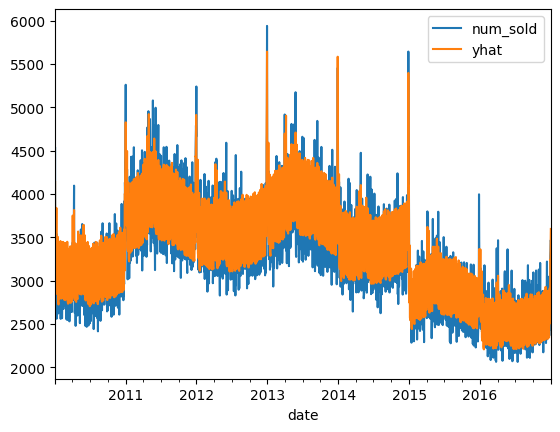

In [52]:
predictions_sample = predictions.query("series_id == 'Norway|Premium Sticker Mart|Kaggle'")

predictions_sample.set_index('date')[['num_sold', 'yhat']].plot.line()

/Users/alexabraham/anaconda3/envs/forecast_stickers_kaggle/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


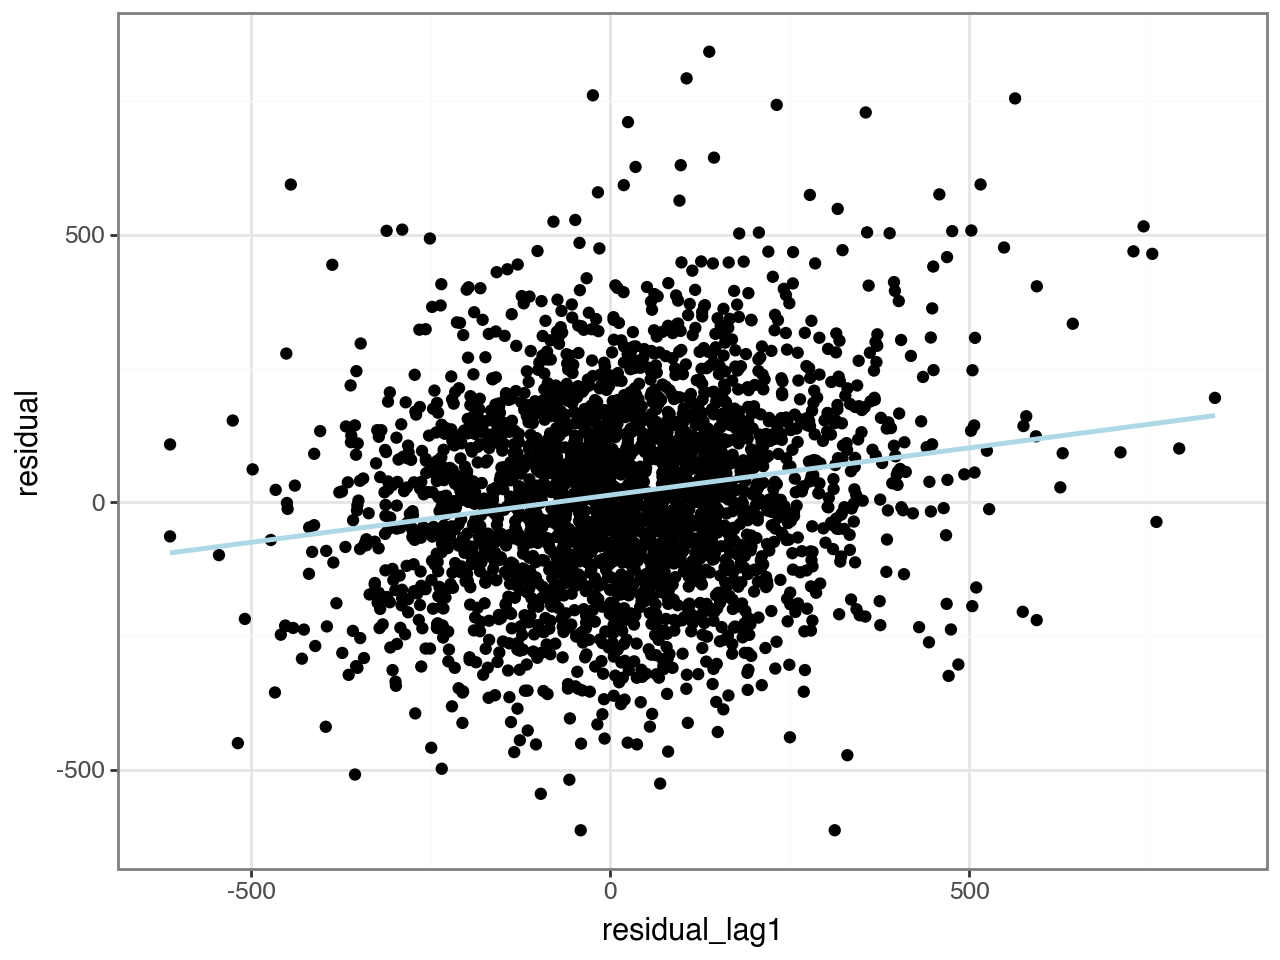

In [53]:
predictions_sample = (
    predictions_sample
    .assign(residual = lambda df_: df_['num_sold'] - df_['yhat'])
    .sort_values('date')
    .assign(
        residual_lag1 = lambda df_: df_['residual'].shift(1),
        residual_lag3 = lambda df_: df_['residual'].shift(3),
        residual_lag7 = lambda df_: df_['residual'].shift(7),
        residual_lag14 = lambda df_: df_['residual'].shift(14),
        )
    )

(
    p9.ggplot(predictions_sample) + 
    p9.theme_bw() + 
    p9.geom_point(p9.aes('residual_lag1', 'residual')) + 
    p9.geom_smooth(p9.aes('residual_lag1', 'residual'), method='lm', se=False, color='lightblue')
)

In [54]:
# (
#     predictions
#     .assign(mape = lambda df_: np.abs(100 * (df_['num_sold']/df_['yhat'] - 1)) )
#     .sort_values('mape', ascending=False)
#     .head(100)
#     .to_csv("./data/processed/predictions_errors_local_model.csv", index=False)
# )

In [55]:
# (
#     predictions
#     .assign(mape = lambda df_: np.abs(100 * (df_['num_sold']/df_['yhat'] - 1)) )
#     .sort_values('mape', ascending=False)
#     .head(50)
# )

In [56]:
# segments_XY = {grp: df for grp, df in XY.groupby('series_id')}

# # even when split into many dataframes, *index-based* subsets.
# # indexes maintained when dataframe splits.
# kfolds = [

#     # validation set 2014-16 matches ultimate test set's length, 2017-19
#     ( 
#         ( (XY['date'] >= pd.to_datetime('2010-01-01')) & (XY['date'] < pd.to_datetime("2014-01-01")) ),
#         XY['date'] >= pd.to_datetime("2014-01-01")
#     ),

#     ( 
#         ( (XY['date'] >= pd.to_datetime('2010-01-01')) & (XY['date'] < pd.to_datetime("2016-01-01")) ),
#         XY['date'] >= pd.to_datetime("2016-01-01")
#     )

#     ]

# kfolds_evaluation = []
# FEATURES_LOCAL_TREND_MODEL = FEATURES_LOCAL_MODEL
# for is_training, is_validation in kfolds:
    
#     segments_models = {
#         grp: (
#             TrendRemainderModelPipeline(FEATURES_LOCAL_TREND_MODEL, RIDGE_ALPHA_TUNED, ['day_of_year'])
#             .fit(XY.loc[is_training, FEATURES_LOCAL_MODEL], XY.loc[is_training, 'num_sold_log'])
#             )
#         for grp, XY in segments_XY.items()
#         }

#     segments_predictions = [
#         df.assign(
#             yhat = lambda df_: np.exp(segments_models[grp].predict(df_[FEATURES_LOCAL_MODEL])) 
#             )
#         for grp, df in segments_XY.items()
#         ]

#     predictions = pd.concat(segments_predictions, axis=0)

#     scores = {
#         'validation': mean_absolute_percentage_error( 
#             predictions.loc[is_validation, 'num_sold'],
#             predictions.loc[is_validation, 'yhat']
#             ),
#         'train': mean_absolute_percentage_error( 
#             predictions.loc[is_training, 'num_sold'],
#             predictions.loc[is_training, 'yhat']
#             )
#         }
    
#     kfolds_evaluation.append(scores)

# kfolds_evaluation

In [57]:
# predictions_sample = predictions.query("series_id == 'Norway|Premium Sticker Mart|Kaggle'")

# predictions_sample.set_index('date')[['num_sold', 'yhat']].plot.line()

In [58]:
SEGMENTS_MODELS = {
    grp: Ridge(RIDGE_ALPHA_TUNED).fit(XY[FEATURES_LOCAL_MODEL], XY['num_sold_log'])
    for grp, XY in segments_XY.items()
    }

In [59]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Deployment

In [51]:
sales_test_daily = pd.read_csv("./data/external/test.csv").assign(

    date = lambda df_: pd.to_datetime(df_['date']),

    country_store = lambda df_: df_['country'].str.cat(df_['store'], sep='|'),
    country_product = lambda df_: df_['country'].str.cat(df_['product'], sep='|'),
    store_product = lambda df_: df_['store'].str.cat(df_['product'], sep='|'),
    country_store_product = lambda df_: df_['country'].str.cat([df_['store'], df_['product']], sep='|')

    ).assign(series_id = lambda df_: df_['country_store_product'])

In [ ]:
sales_test_daily.head()

In [ ]:
sales_test_daily['date'].describe()

In [54]:
sales_test_daily = transform_calendar_features(sales_test_daily)
sales_test_daily = integrate_external_features(sales_test_daily)

In [55]:
sales_test_daily = sales_test_daily.assign(
    num_sold = None,
    num_sold_log = None
)
sales_test_enriched_daily = feature_transform_pipeline.transform(sales_test_daily)

In [56]:
segments_X_test = {grp: df for grp, df in sales_test_enriched_daily.groupby('series_id')}

segments_predictions_test = []
for grp, df in segments_X_test.items():

    if grp in SEGMENTS_MODELS:
        df = df.assign(
            yhat = lambda df_: np.exp(SEGMENTS_MODELS[grp].predict(df_[FEATURES_LOCAL_MODEL])) 
            )  
    else:
        df = df.assign(
            yhat = lambda df_: np.exp(model_global.predict(df_[FEATURES_GLOBAL_MODEL])) 
            )

    segments_predictions_test.append(df)

predictions_test = pd.concat(segments_predictions_test, axis=0)

In [57]:
predictions_test_submit = (
    predictions_test
    [['id', 'yhat']]
    .rename(columns={'yhat': 'num_sold'})
    )

In [58]:
assert predictions_test_submit.shape[0] == 98_550
assert predictions_test_submit.notnull().all().all()
predictions_test_submit.to_csv("./data/processed/submission5.csv", index=False)